In [136]:
# f = (f' - B - d * t) / med (f' - b - d * t)
# D = D' - B
# B = B' + Berr

In [137]:
import numpy as np
import matplotlib.pyplot as plt

In [138]:
# number of pixels in rows and columns, can change with the dimension of the CCD
rows = 100
columns = 100
# dark counts per second per pixel 
dark = 2 
# the flactuation of flat with a 3% error
flatUpper = 1.03
flatLower = 0.97
# bias counts and overall bias level change
bias = 4000
biasChangeUpper = 0.2
biasChangeLower = 0.01
# integration time 
time = 300 

# flat field randomization
flatField = np.matrix([[np.random.uniform(flatLower, flatUpper) for _ in range(columns)] for _ in range(rows)])

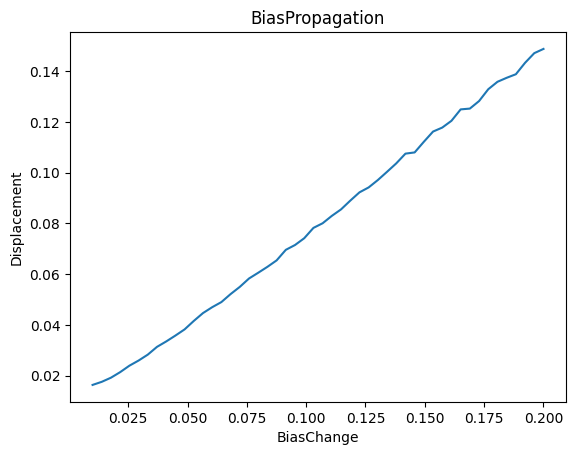

In [139]:
#change for the bias
biasChange = np.linspace(biasChangeLower, biasChangeUpper)
# flat field propagation 
mean_displacement = []
for b in biasChange:  
    master_bias = np.matrix([[np.random.normal(bias, bias * b) for _ in range(columns)] for _ in range(rows)])
    master_dark = dark * time + master_bias
    flat = flatField - master_dark - master_bias
    flat /= np.mean(flat)
    displacement = np.mean(np.abs((flat - flatField)) / flatField)
    mean_displacement.append(displacement) 
    
plt.plot(biasChange, mean_displacement)
plt.title("BiasPropagation")
# naming the x axis
plt.xlabel('BiasChange')
# naming the y axis
plt.ylabel('Displacement')
plt.show()

The slope is 0.718 +/- 0.003
The intercept is 0.004 +/- 0.000


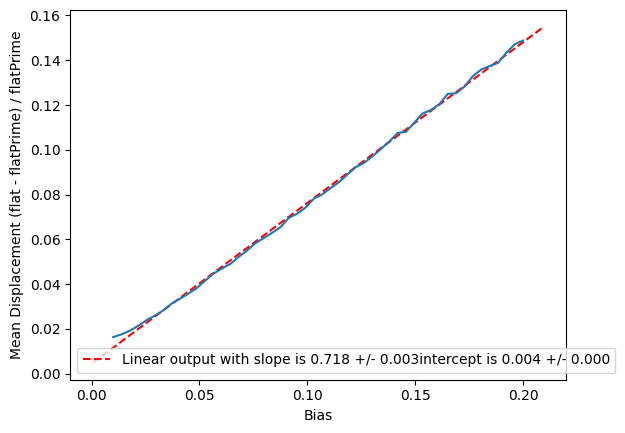

In [140]:
fit = np.polyfit(biasChange, mean_displacement,1,full=False, cov=True)


# Fit parameters are the first element in the returned "tuple"
fitparams = fit[0]
slope = fitparams[0]
intercept = fitparams[1]

# Covariance matrix is the second element in the returned "tuple"
cov = fit[1]

# This is the way you get errors out of the covariance matrix.
param_error = np.sqrt(np.diagonal(cov))
slope_error = param_error[0]
intercept_error = param_error[1]

slope_output = 'slope is %.3f +/- %0.3f' %(slope,slope_error)
intercept_output = 'intercept is %.3f +/- %0.3f' %(intercept,intercept_error)

plt.errorbar(biasChange,mean_displacement)
plt.xlabel('Bias')
plt.ylabel('Mean Displacement (flat - flatPrime) / flatPrime')
xfit = np.linspace(plt.xlim()[0],plt.xlim()[1],100)
yfit = intercept + slope*xfit
plt.plot(xfit,yfit,'r--', label='Linear output with ' + slope_output + intercept_output)
plt.legend()

print('The slope is %.3f +/- %0.3f' %(slope,slope_error))
print('The intercept is %.3f +/- %0.3f' %(intercept,intercept_error))
# plt.savefig('Updated Linear model')

Text(0.5, 1.0, 'Normal Distribution')

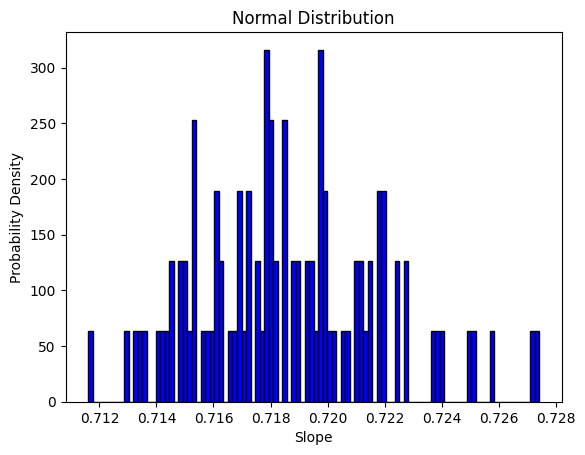

In [141]:
slope_normal = np.random.normal(slope, slope_error, bin)
plt.hist(slope_normal, bin, density = True, color='b', edgecolor='black')
plt.xlabel('Slope')
plt.ylabel('Probability Density')
plt.title('Normal Distribution')
# plt.savefig('Slope Hist')


Text(0.5, 1.0, 'Normal Distribution')

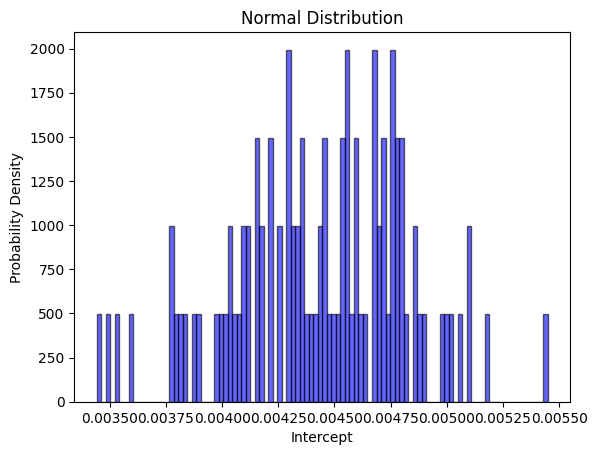

In [142]:
intercept_normal = np.random.normal(intercept, intercept_error, bin)
plt.hist(intercept_normal, bin, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlabel('Intercept')
plt.ylabel('Probability Density')
plt.title('Normal Distribution')
# plt.savefig('Intercept Hist')